**Nama : Wahyu Bagus Wicaksono**

**Grup : M07**

Import Semua Library yang dibutuhkan

In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM, Bidirectional
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

Menampilkan Data dari CSV dan mengubah tipedata dari Date ke datetime dan Volume ke float

Data yang digunakan : https://www.kaggle.com/datasets/varpit94/apple-stock-data-updated-till-22jun2021

In [36]:
data_train = pd.read_csv('AAPL.csv')
# data_train.head(100)
data_train['Date'] =  pd.to_datetime(data_train['Date'])
data_train['Volume'] = data_train['Volume'].astype(float)

df = pd.DataFrame(data_train)
df

print(df.dtypes)

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
dtype: object


Menampilkan plot dari data High dengan sumbu X yaitu date dan Y adalah price

Text(0, 0.5, 'Price')

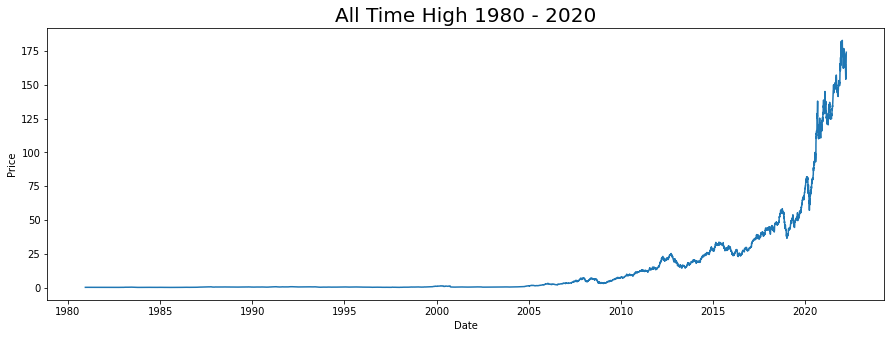

In [60]:
dates = data_train['Date'].values
high = data_train['High'].values


plt.figure(figsize=(15,5))
plt.plot(dates, high)
plt.title('All Time High 1980 - 2020',
          fontsize=20)
plt.xlabel('Date')
plt.ylabel('Price')

Membuat varibel yang digunakan untuk training data

In [41]:
cols = list(df)[1:7]
df_cols = df[cols].astype(float)

             Open        High         Low       Close   Adj Close       Volume
0        0.128348    0.128906    0.128348    0.128348    0.100323  469033600.0
1        0.122210    0.122210    0.121652    0.121652    0.095089  175884800.0
2        0.113281    0.113281    0.112723    0.112723    0.088110  105728000.0
3        0.115513    0.116071    0.115513    0.115513    0.090291   86441600.0
4        0.118862    0.119420    0.118862    0.118862    0.092908   73449600.0
...           ...         ...         ...         ...         ...          ...
10404  160.509995  164.479996  159.759995  163.979996  163.979996  123351200.0
10405  163.509995  166.350006  163.009995  165.380005  165.380005   95811400.0
10406  165.509995  169.419998  164.910004  168.820007  168.820007   81532000.0
10407  167.990005  172.639999  167.649994  170.210007  170.210007   98062700.0
10408  171.059998  174.139999  170.210007  174.070007  174.070007   90018700.0

[10409 rows x 6 columns]


Menormalisasikan data dengan StandardScaler selain dengan StandardScaler kita juga bisa menggunakan MinMaxScaler

In [44]:
scaler = preprocessing.StandardScaler()
scalerData = scaler.fit(df_cols)
df_cols_scale = scalerData.transform(df_cols)

[[-0.45848767 -0.45825848 -0.45857038 -0.45837351 -0.44300062  0.4033258 ]
 [-0.45869113 -0.45847792 -0.45879483 -0.4585953  -0.44317562 -0.4606092 ]
 [-0.45898711 -0.45877055 -0.45909412 -0.45889106 -0.44340895 -0.66736739]
 ...
 [ 5.02357192  5.08982943  5.06478366  5.1292477   5.19796907 -0.73867511]
 [ 5.10577912  5.19535683  5.15662601  5.17528906  5.2444423  -0.6899577 ]
 [ 5.20754304  5.24451554  5.24243567  5.30314492  5.37349744 -0.71366406]]


Merubah array dates ke tipe data float32 dan array high ke tipe data float32

In [58]:
dates = np.asarray(dates).astype('float32')
high = np.asarray(high).astype('float32')


[3.4542721e+17 3.4568639e+17 3.4577280e+17 ... 1.6479072e+18 1.6479937e+18
 1.6480800e+18]


Melakukan reshape terhadap array trainX dan trainY

In [61]:
trainX = []
trainY = []

n_f = 2 #Jumlah hari yang digunakan untuk memprediksi masa depan dari hari N
n_past = 3 #Jumlah hari kemaren yang digunakan untuk memprediksi masa depan dari hari N

for i in range(n_past, len(df_cols_scale) - n_f+1):
  trainX.append(df_cols_scale[i - n_past:i, 0:df_cols.shape[1]])
  trainY.append(df_cols_scale[i + n_f - 1:i + n_f,0])

trainX, trainY = np.array(trainX), np.array(trainY)

print(trainX.shape, trainY.shape)


(10405, 3, 6) (10405, 1)


Membangun model Sequential dengan LSTM

In [62]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(256, activation='relu', return_sequences=True),
  tf.keras.layers.LSTM(128, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1),
])


Membuat callbacks, jika MAE sudah dibawah 10%, maka train model akan berhenti

In [63]:
# Berhenti ketika MAE dibawah 10%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< 0.1):
      print("\nMAE kurang dari 10%")
      self.model.stop_training = True

callbacks = myCallback()

Latih model dengan mode.fit dan menyimpannya ke dalam variabel history guna memudahkan proses plotting

In [64]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(trainX,
                    trainY,
                    epochs=100,
                    validation_split=0.2, # Validation set sebesar 20% dari dataset
                    callbacks=[callbacks],
                    verbose=1)

Epoch 1/100
261/261 [==============================] - 10s 27ms/step - loss: 0.0538 - mae: 0.3106 - val_loss: 1.2122 - val_mae: 1.6770
Epoch 2/100
261/261 [==============================] - 7s 25ms/step - loss: 0.0264 - mae: 0.2044 - val_loss: 1.2830 - val_mae: 1.7602
Epoch 3/100
261/261 [==============================] - 7s 25ms/step - loss: 0.0208 - mae: 0.1661 - val_loss: 1.3116 - val_mae: 1.7927
Epoch 4/100
261/261 [==============================] - 7s 25ms/step - loss: 0.0194 - mae: 0.1552 - val_loss: 1.3237 - val_mae: 1.8061
Epoch 5/100
261/261 [==============================] - 7s 25ms/step - loss: 0.0184 - mae: 0.1483 - val_loss: 1.3307 - val_mae: 1.8138
Epoch 6/100
261/261 [==============================] - 7s 25ms/step - loss: 0.0175 - mae: 0.1427 - val_loss: 1.3341 - val_mae: 1.8174
Epoch 7/100
261/261 [==============================] - 7s 25ms/step - loss: 0.0172 - mae: 0.1402 - val_loss: 1.3370 - val_mae: 1.8206
Epoch 8/100
261/261 [==============================] - 6s 25m

Scatter plot Training dan Validation MAE

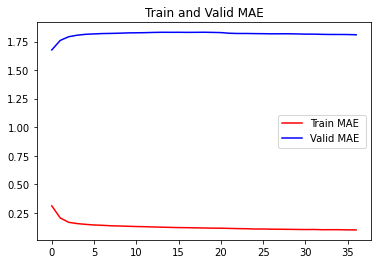

<Figure size 432x288 with 0 Axes>

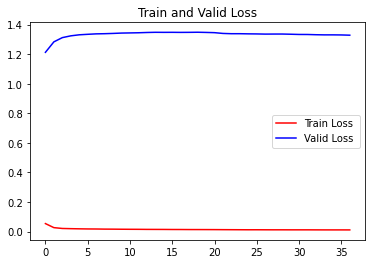

<Figure size 432x288 with 0 Axes>

In [65]:
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(mae))

plt.plot(epochs, mae, 'r', label='Train MAE ')                
plt.plot(epochs, val_mae, 'b', label='Valid MAE')
plt.title('Train and Valid MAE')
plt.legend(loc=0)
plt.figure()                                                                      
plt.show()

plt.plot(epochs, loss, 'r', label='Train Loss ')                
plt.plot(epochs, val_loss, 'b', label='Valid Loss')
plt.title('Train and Valid Loss')
plt.legend(loc=0)
plt.figure()                                                                      
plt.show()